In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, auc, precision_recall_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../")
from src.utils import pr_auc_macro

In [9]:
generated_features_df = pd.read_parquet("../preprocessed/generated_features.parquet")

In [10]:
generated_features_df.head(3)

,target,variantid1,variantid2,categories1,same_categories4,same_categories2,same_categories3,same_Бренд,same_Тип,same_Цвет товара,...,jaccard_Процессор,overlap_Процессор,jaccard_Модуль связи WiFi,overlap_Модуль связи WiFi,name_bert_dot,name_bert_cos,name_bert_euc,resnet_dot,resnet_bert_cos,resnet_bert_euc
0,0.0,51197862,51198054,"Сетевые фильтры, разветвители и удлинители",1,1,1,1,1,1,...,-1.0,-1.0,-1.0,-1.0,15.188051,0.003606,0.338458,86.646202,0.000387,0.259265
1,0.0,51197862,51199884,"Сетевые фильтры, разветвители и удлинители",1,1,1,1,1,1,...,-1.0,-1.0,-1.0,-1.0,15.313345,0.007311,0.475419,86.537857,0.000456,0.282023
2,1.0,53062686,536165289,Расходник для печати,1,1,1,1,1,-1,...,-1.0,-1.0,-1.0,-1.0,15.343762,0.010588,0.577868,41.408783,0.012371,1.078670


In [31]:
X = generated_features_df.drop(["target"], axis=1)
y = generated_features_df['target'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()

rf.fit(X_train.drop(['categories1', "variantid1", "variantid2"], axis=1), y_train)


RandomForestClassifier()

In [32]:
preds = rf.predict(X_test.drop(["categories1", "variantid1", "variantid2"], axis=1))
similarities = rf.predict_proba(X_test.drop(["categories1", "variantid1", "variantid2"], axis=1))

In [33]:
X_test['target'] = y_test
X_test['scores'] = similarities[:, 1]
y_val = X_test[[ 'target', 'variantid1', 'variantid2']]
X_val = X_test[['categories1', 'scores', 'variantid1', 'variantid2']]

In [34]:
pr_auc_macro(target_df=y_val, predictions_df=X_val, cat_column='categories1')

0.5714801442350455

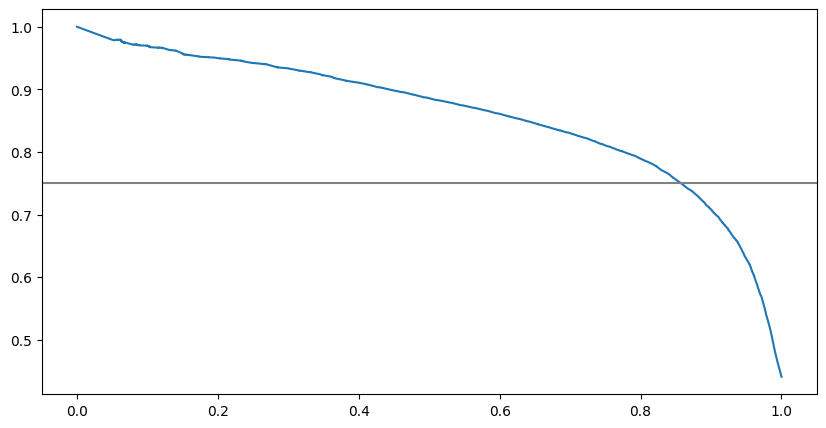

In [35]:
precision, recall, thrs = precision_recall_curve(y_test, X_test['scores'].to_numpy())
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(10, 5))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-')
plt.show()

In [36]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84     34279
         1.0       0.78      0.81      0.80     27029

    accuracy                           0.82     61308
   macro avg       0.82      0.82      0.82     61308
weighted avg       0.82      0.82      0.82     61308

